## 1. Załadowanie danych

In [35]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("📦 Libraries loaded")

📦 Libraries loaded


## 2. Wczytanie prompts i rezultatów

In [36]:
# Wczytaj prompts (same 20)
df = pd.read_csv('prompts2.csv', sep=';')
df = df.iloc[:20].copy()  # Same 20 jak w test_groq
expected_labels = df['Flag'].values

print(f"✓ Prompts loaded: {df.shape}")
print(f"True/False: {dict(pd.Series(expected_labels).value_counts())}")

✓ Prompts loaded: (20, 2)
True/False: {1: np.int64(11), 0: np.int64(9)}


## 3. Załadowanie ostatnich wyników Groq

In [37]:
def load_latest_groq_results():
    """Załaduj ostatnio zapisane wyniki Groq"""
    folder = "saved_responses_groq"
    
    if not os.path.exists(folder):
        print(f"[ERROR] Folder '{folder}' nie istnieje!")
        return None, None
    
    # Znajdź najnowsze pliki
    parsed_files = [f for f in os.listdir(folder) if f.startswith('parsed_responses_')]
    if not parsed_files:
        print(f"[ERROR] Brak plików parsed_responses w {folder}")
        return None, None
    
    latest_timestamp = sorted(parsed_files)[-1]  # Najnowszy plik
    timestamp = latest_timestamp.replace('parsed_responses_', '').replace('.csv', '')
    
    parsed_path = os.path.join(folder, f"parsed_responses_{timestamp}.csv")
    raw_path = os.path.join(folder, f"raw_responses_{timestamp}.csv")
    
    try:
        parsed_df = pd.read_csv(parsed_path, index_col=0)
        raw_df = pd.read_csv(raw_path, index_col=0)
        
        print("[OK] ZAŁADOWANE WYNIKI GROQ")
        print("="*80)
        print(f"Parsed: {os.path.basename(parsed_path)}")
        print(f"        {parsed_df.shape[0]} wierszy × {parsed_df.shape[1]} kolumn (strategie)")
        print(f"\nRaw:    {os.path.basename(raw_path)}")
        print(f"        {raw_df.shape[0]} wierszy × {raw_df.shape[1]} kolumn")
        print("="*80)
        
        return parsed_df, raw_df
    except Exception as e:
        print(f"[ERROR] Błąd ładowania: {e}")
        return None, None

parsed_df, raw_df = load_latest_groq_results()

[OK] ZAŁADOWANE WYNIKI GROQ
Parsed: parsed_responses_2025-12-31_00-25-21.csv
        20 wierszy × 12 kolumn (strategie)

Raw:    raw_responses_2025-12-31_00-25-21.csv
        20 wierszy × 12 kolumn


## 4. Metryki per strategia

In [38]:
print("\n📊 METRYKI PER STRATEGIA")
print("="*100)

metrics_list = []

for col in parsed_df.columns:
    y_pred = parsed_df[col].values
    
    valid_mask = ~pd.isna(y_pred)
    if valid_mask.sum() == 0:
        continue
    
    y_pred_valid = y_pred[valid_mask]
    y_true_valid = expected_labels[valid_mask]
    
    acc = accuracy_score(y_true_valid, y_pred_valid)
    prec = precision_score(y_true_valid, y_pred_valid, zero_division=0)
    rec = recall_score(y_true_valid, y_pred_valid, zero_division=0)
    f1 = f1_score(y_true_valid, y_pred_valid, zero_division=0)
    
    metrics_list.append({
        'Strategy': col,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'Valid': valid_mask.sum(),
        'Total': len(y_pred)
    })
    
    parse_rate = valid_mask.sum() / len(y_pred) * 100
    print(f"{col:25} | Acc: {acc:.3f} | F1: {f1:.3f} | Valid: {valid_mask.sum():2}/{len(y_pred)} ({parse_rate:5.1f}%)")

metrics_df = pd.DataFrame(metrics_list).sort_values('Accuracy', ascending=False)

print("\n" + "="*100)
print(f"ŚREDNIA ACCURACY:  {metrics_df['Accuracy'].mean():.3f}")
print(f"ŚREDNIA F1:        {metrics_df['F1'].mean():.3f}")
print(f"\nBest Strategy:  {metrics_df.iloc[0]['Strategy']:25} (Acc: {metrics_df.iloc[0]['Accuracy']:.3f})")
print(f"Worst Strategy: {metrics_df.iloc[-1]['Strategy']:25} (Acc: {metrics_df.iloc[-1]['Accuracy']:.3f})")
print(f"\nDifference (Best - Worst): {metrics_df.iloc[0]['Accuracy'] - metrics_df.iloc[-1]['Accuracy']:.3f}")


📊 METRYKI PER STRATEGIA
Prompt                    | Acc: 0.650 | F1: 0.741 | Valid: 20/20 (100.0%)
Negative_prompt           | Acc: 0.700 | F1: 0.727 | Valid: 20/20 (100.0%)
Positive_prompt           | Acc: 0.700 | F1: 0.750 | Valid: 20/20 (100.0%)
Positive_Extra_role       | Acc: 0.700 | F1: 0.750 | Valid: 20/20 (100.0%)
Negative_Extra_role       | Acc: 0.600 | F1: 0.714 | Valid: 20/20 (100.0%)
Uncertainty_prompt        | Acc: 0.700 | F1: 0.750 | Valid: 20/20 (100.0%)
Scrambled_prompt          | Acc: 0.000 | F1: 0.000 | Valid:  1/20 (  5.0%)
Chain_of_thoughts         | Acc: 0.750 | F1: 0.800 | Valid: 20/20 (100.0%)
Sceptical_role            | Acc: 0.700 | F1: 0.769 | Valid: 20/20 (100.0%)
High_stakes               | Acc: 0.650 | F1: 0.741 | Valid: 20/20 (100.0%)
Tipping                   | Acc: 0.600 | F1: 0.692 | Valid: 20/20 (100.0%)
Random_mistake            | Acc: 0.550 | F1: 0.667 | Valid: 20/20 (100.0%)

ŚREDNIA ACCURACY:  0.608
ŚREDNIA F1:        0.675

Best Strategy:  Chain_o

## 5. Ranking Strategii

In [39]:
# Zapisz ranking
ranking_df = metrics_df[['Strategy', 'Accuracy', 'F1', 'Precision', 'Recall']].copy()
ranking_df = ranking_df.reset_index(drop=True)
ranking_df.index = ranking_df.index + 1
ranking_df.index.name = 'Rank'

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
ranking_path = os.path.join('saved_responses_groq', f'ranking_strategies_{timestamp}.csv')
ranking_df.to_csv(ranking_path, encoding='utf-8-sig')

print("\n🏆 RANKING STRATEGII")
print("="*80)
print(ranking_df.to_string())
print(f"\n✓ Saved: {ranking_path}")


🏆 RANKING STRATEGII
                 Strategy  Accuracy        F1  Precision    Recall
Rank                                                              
1       Chain_of_thoughts      0.75  0.800000   0.714286  0.909091
2         Negative_prompt      0.70  0.727273   0.727273  0.727273
3     Positive_Extra_role      0.70  0.750000   0.692308  0.818182
4         Positive_prompt      0.70  0.750000   0.692308  0.818182
5          Sceptical_role      0.70  0.769231   0.666667  0.909091
6      Uncertainty_prompt      0.70  0.750000   0.692308  0.818182
7                  Prompt      0.65  0.740741   0.625000  0.909091
8             High_stakes      0.65  0.740741   0.625000  0.909091
9                 Tipping      0.60  0.692308   0.600000  0.818182
10    Negative_Extra_role      0.60  0.714286   0.588235  0.909091
11         Random_mistake      0.55  0.666667   0.562500  0.818182
12       Scrambled_prompt      0.00  0.000000   0.000000  0.000000

✓ Saved: saved_responses_groq\ranking_st

## WYKRES 1: Bar Chart - Ranking Accuracy

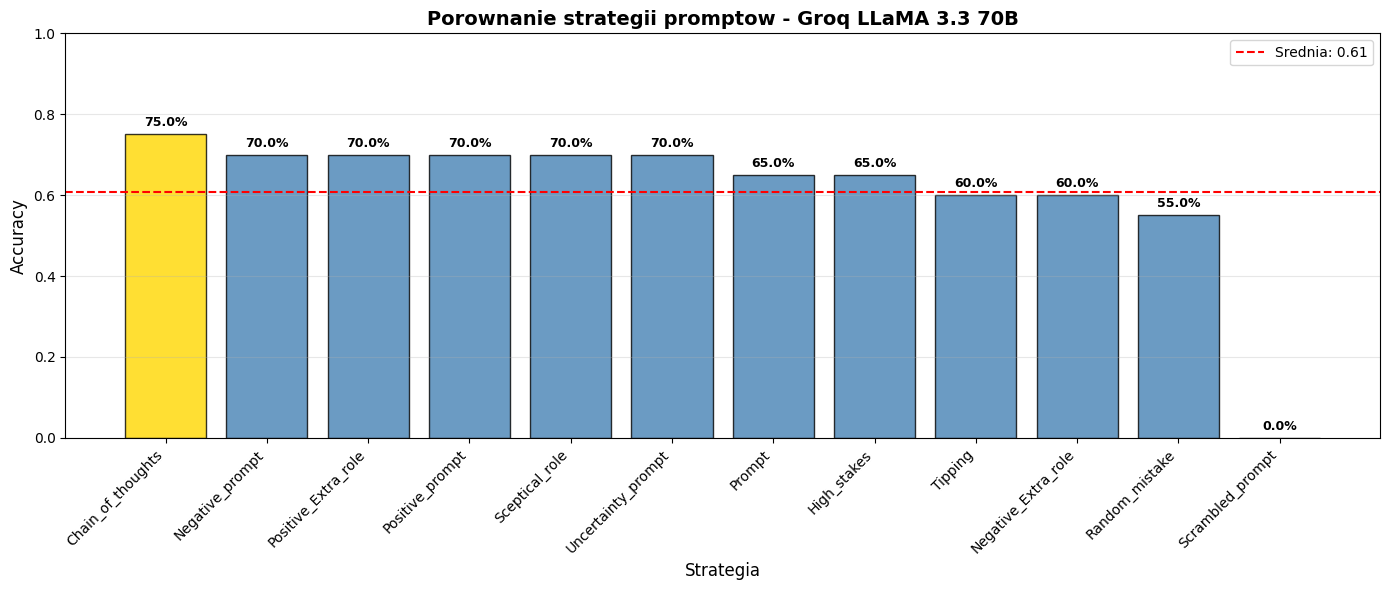

In [40]:
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['gold' if i == 0 else 'steelblue' for i in range(len(metrics_df))]
bars = ax.bar(metrics_df['Strategy'], metrics_df['Accuracy'], color=colors, alpha=0.8, edgecolor='black')

ax.set_xlabel('Strategia', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Porownanie strategii promptow - Groq LLaMA 3.3 70B', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.axhline(y=metrics_df['Accuracy'].mean(), color='red', linestyle='--', label=f'Srednia: {metrics_df["Accuracy"].mean():.2f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, (s, a) in enumerate(zip(metrics_df['Strategy'], metrics_df['Accuracy'])):
    ax.text(i, a + 0.02, f'{a:.1%}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## WYKRES 2: Confusion Matrix - Top 3 strategie

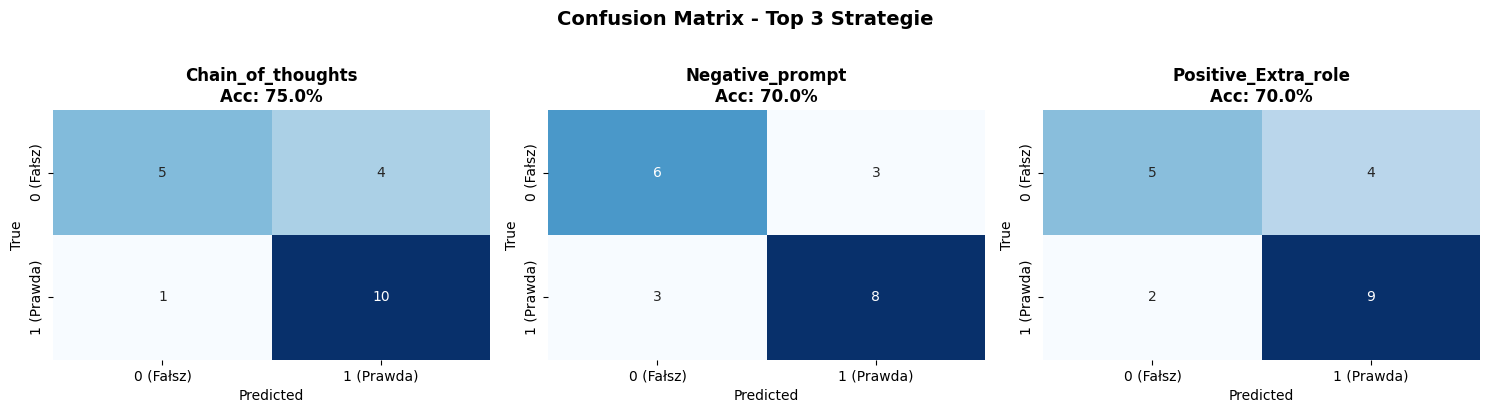

In [41]:
top3 = metrics_df.head(3)['Strategy'].tolist()
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, strategy in enumerate(top3):
    y_pred = parsed_df[strategy].values
    valid_mask = ~pd.isna(y_pred)
    
    cm = confusion_matrix(expected_labels[valid_mask], y_pred[valid_mask].astype(int))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx],
                xticklabels=['0 (Fałsz)', '1 (Prawda)'], yticklabels=['0 (Fałsz)', '1 (Prawda)'])
    
    acc = metrics_df[metrics_df['Strategy'] == strategy]['Accuracy'].values[0]
    axes[idx].set_title(f'{strategy}\nAcc: {acc:.1%}', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.suptitle('Confusion Matrix - Top 3 Strategie', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## WYKRES 3: Heatmapa poprawnosci + Ranking

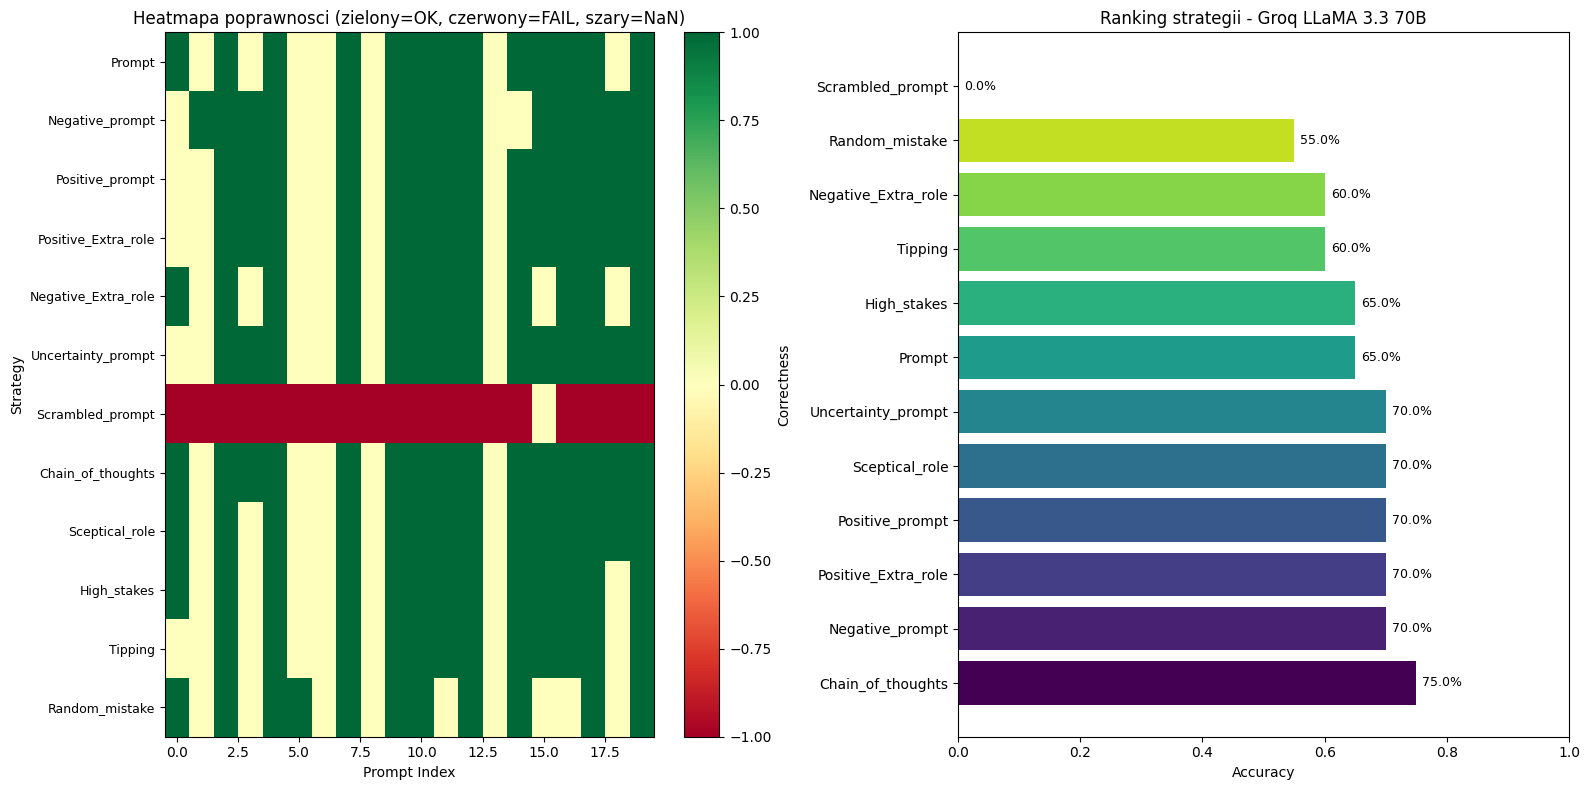

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Heatmapa poprawnosci
correctness_matrix = np.zeros((len(parsed_df.columns), len(parsed_df)))
for i, strategy in enumerate(parsed_df.columns):
    for j in range(len(parsed_df)):
        pred = parsed_df[strategy].iloc[j]
        if pd.isna(pred):
            correctness_matrix[i][j] = -1
        else:
            correctness_matrix[i][j] = 1 if pred == expected_labels[j] else 0

im1 = ax1.imshow(correctness_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax1.set_xlabel('Prompt Index')
ax1.set_ylabel('Strategy')
ax1.set_yticks(range(len(parsed_df.columns)))
ax1.set_yticklabels(parsed_df.columns, fontsize=9)
ax1.set_title('Heatmapa poprawnosci (zielony=OK, czerwony=FAIL, szary=NaN)')
plt.colorbar(im1, ax=ax1, label='Correctness')

# Ranking
strategies = metrics_df['Strategy'].values
accuracies = metrics_df['Accuracy'].values
colors = plt.cm.viridis(np.linspace(0, 1, len(strategies)))

ax2.barh(strategies, accuracies, color=colors)
ax2.set_xlabel('Accuracy')
ax2.set_title('Ranking strategii - Groq LLaMA 3.3 70B')
ax2.set_xlim(0, 1)
for i, (s, acc) in enumerate(zip(strategies, accuracies)):
    ax2.text(acc + 0.01, i, f'{acc:.1%}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Interactive Explorer - eksploracja przypadkow

In [43]:
import ipywidgets as widgets
from IPython.display import display

def create_interactive_explorer():
    output_area = widgets.Output()
    
    idx_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(parsed_df)-1,
        description='Prompt ID:',
        continuous_update=False
    )
    
    def update_display(idx):
        with output_area:
            output_area.clear_output()
            
            original_prompt = df.iloc[idx]['Prompt']
            ground_truth = int(expected_labels[idx])
            
            print(f"[Prompt #{idx}] {original_prompt[:120]}...")
            print(f"Ground Truth: {ground_truth}\n")
            
            results = []
            for strategy in parsed_df.columns:
                pred = parsed_df[strategy].iloc[idx]
                if not pd.isna(pred):
                    pred = int(pred)
                    is_correct = (pred == ground_truth)
                    status = 'OK' if is_correct else 'FAIL'
                    results.append(f"  {strategy:25s} -> {pred} [{status}]")
                else:
                    results.append(f"  {strategy:25s} -> NaN [ERROR]")
            
            print("\n".join(results))
            
            # Zmiennosc
            row_var = [v for v in variability_per_prompt if v['Prompt_Index'] == idx]
            if row_var:
                print(f"\nZmiennosc: std={row_var[0]['Variability']:.3f}, konflikt={row_var[0]['Conflict']}")
    
    idx_slider.observe(lambda change: update_display(change['new']), names='value')
    update_display(0)
    
    display(idx_slider, output_area)

create_interactive_explorer()

IntSlider(value=0, continuous_update=False, description='Prompt ID:', max=19)

Output()

## Analiza kategorii strategii


[Analiza kategorii strategii]
Positive Framing          | 70.0% | +5.0% [pomaga]
Negative Framing          | 70.0% | +5.0% [pomaga]
Role-Playing (Expert)     | 70.0% | +5.0% [pomaga]
Role-Playing (Dummy)      | 60.0% | -5.0% [szkodzi]
Chain-of-Thought          | 75.0% | +10.0% [pomaga]
Uncertainty               | 70.0% | +5.0% [pomaga]
Scepticism                | 70.0% | +5.0% [pomaga]
Incentive                 | 62.5% | -2.5% [szkodzi]
Scramble/Noise            | 27.5% | -37.5% [szkodzi]


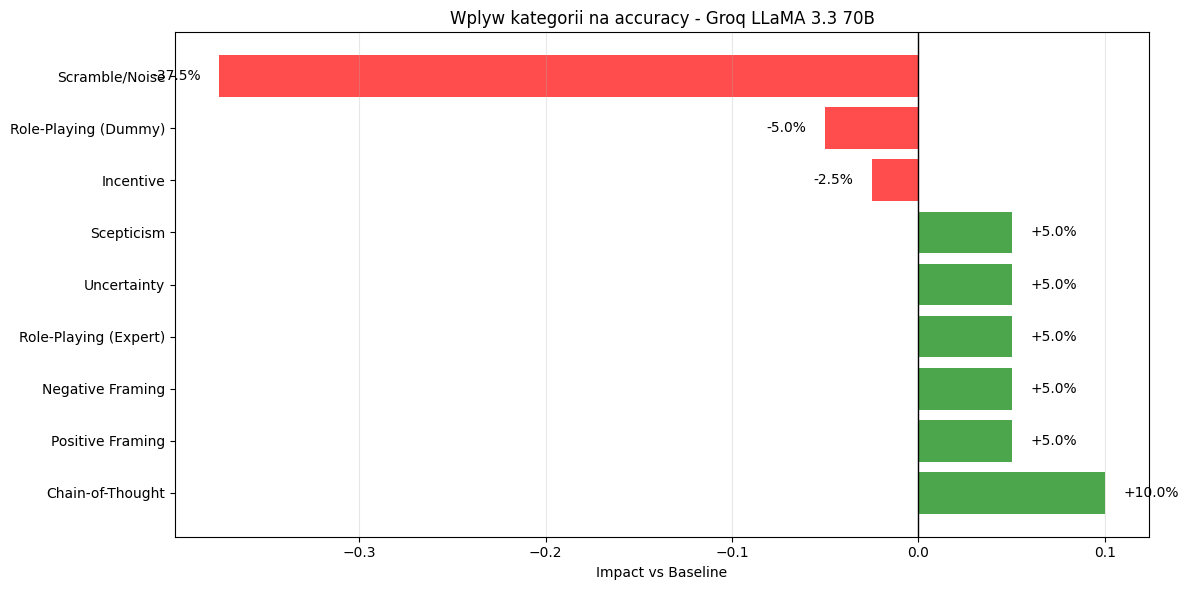


[Wzorce: X -> Y]
  Dodanie 'Chain-of-Thought' -> zwieksza accuracy o 10.0pp
  Dodanie 'Positive Framing' -> zwieksza accuracy o 5.0pp
  Dodanie 'Negative Framing' -> zwieksza accuracy o 5.0pp
  Dodanie 'Role-Playing (Expert)' -> zwieksza accuracy o 5.0pp
  Dodanie 'Uncertainty' -> zwieksza accuracy o 5.0pp
  Dodanie 'Scepticism' -> zwieksza accuracy o 5.0pp
  Dodanie 'Incentive' -> zmniejsza accuracy o 2.5pp
  Dodanie 'Role-Playing (Dummy)' -> zmniejsza accuracy o 5.0pp
  Dodanie 'Scramble/Noise' -> zmniejsza accuracy o 37.5pp


In [44]:
print("\n[Analiza kategorii strategii]")

categories = {
    'Positive Framing': ['Positive_prompt'],
    'Negative Framing': ['Negative_prompt'],
    'Role-Playing (Expert)': ['Positive_Extra_role'],
    'Role-Playing (Dummy)': ['Negative_Extra_role'],
    'Chain-of-Thought': ['Chain_of_thoughts'],
    'Uncertainty': ['Uncertainty_prompt'],
    'Scepticism': ['Sceptical_role'],
    'Incentive': ['Tipping', 'High_stakes'],
    'Scramble/Noise': ['Scrambled_prompt', 'Random_mistake']
}

category_performance = []
baseline_acc = metrics_df[metrics_df['Strategy'] == 'Prompt']['Accuracy'].values[0]

for cat_name, cat_strategies in categories.items():
    cat_metrics = metrics_df[metrics_df['Strategy'].isin(cat_strategies)]
    if len(cat_metrics) > 0:
        avg_acc = cat_metrics['Accuracy'].mean()
        impact = avg_acc - baseline_acc
        
        category_performance.append({
            'Category': cat_name,
            'Avg_Accuracy': avg_acc,
            'Baseline': baseline_acc,
            'Impact': impact,
            'N_Strategies': len(cat_strategies)
        })
        
        impact_text = "pomaga" if impact > 0.02 else "szkodzi" if impact < -0.02 else "neutralne"
        print(f"{cat_name:25s} | {avg_acc:.1%} | {impact:+.1%} [{impact_text}]")

cat_perf_df = pd.DataFrame(category_performance).sort_values('Impact', ascending=False)

# Wykres
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in cat_perf_df['Impact']]
ax.barh(cat_perf_df['Category'], cat_perf_df['Impact'], color=colors, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Impact vs Baseline')
ax.set_title('Wplyw kategorii na accuracy - Groq LLaMA 3.3 70B')
ax.grid(axis='x', alpha=0.3)

for i, (cat, imp) in enumerate(zip(cat_perf_df['Category'], cat_perf_df['Impact'])):
    ax.text(imp + (0.01 if imp > 0 else -0.01), i, f'{imp:+.1%}', 
            ha='left' if imp > 0 else 'right', va='center')

plt.tight_layout()
plt.show()

print("\n[Wzorce: X -> Y]")
for _, row in cat_perf_df.iterrows():
    if abs(row['Impact']) > 0.02:
        direction = "zwieksza" if row['Impact'] > 0 else "zmniejsza"
        print(f"  Dodanie '{row['Category']}' -> {direction} accuracy o {abs(row['Impact'])*100:.1f}pp")

## 6. Analiza zmienności (variability) - Halucynacje

In [45]:
# Zmienność między strategiami - czy model daje różne odpowiedzi na te same prompty?
print("\n🚨 ANALIZA HALUCYNACJI (ZMIENNOŚĆ MIĘDZY STRATEGIAMI)")
print("="*80)

# Dla każdego promptu: ile strategii się nie zgadza?
variability_per_prompt = []
hallucination_cases = []

for idx in parsed_df.index:
    row = parsed_df.loc[idx]
    valid_predictions = row.dropna().values
    
    if len(valid_predictions) == 0:
        continue
    
    # Variability = std dev
    variability = np.std(valid_predictions)
    
    # Czy są conflicting predictions?
    has_conflict = (0 in valid_predictions) and (1 in valid_predictions)
    
    variability_per_prompt.append({
        'Prompt_Index': idx,
        'Variability': variability,
        'Conflict': has_conflict,
        'Unanimous': not has_conflict,
        'All_Predictions': valid_predictions.tolist()
    })
    
    if variability > 0.35:  # TOP halucynacje
        hallucination_cases.append({
            'Prompt_Index': idx,
            'Variability': variability,
            'True_Label': expected_labels[idx],
            'Strategy_Scores': row.to_dict()
        })

variability_df = pd.DataFrame(variability_per_prompt)

conflict_count = variability_df['Conflict'].sum()
unanimous_count = variability_df['Unanimous'].sum()

print(f"\nPrompty z konfliktami (różne strategie dają różne odpowiedzi):")
print(f"  Konflikt: {conflict_count}/{len(variability_df)} ({conflict_count/len(variability_df)*100:.1f}%)")
print(f"  Unanimus (zgoda): {unanimous_count}/{len(variability_df)} ({unanimous_count/len(variability_df)*100:.1f}%)")

print(f"\nZmienność (std dev):")
print(f"  Średnia: {variability_df['Variability'].mean():.3f}")
print(f"  Median:  {variability_df['Variability'].median():.3f}")
print(f"  Max:     {variability_df['Variability'].max():.3f}")
print(f"  Min:     {variability_df['Variability'].min():.3f}")

# Zapisz TOP halucynacje
if hallucination_cases:
    hallucination_df = pd.DataFrame([{
        'Prompt_Index': h['Prompt_Index'],
        'Variability': h['Variability'],
        'True_Label': h['True_Label']
    } for h in hallucination_cases])
    
    hallucination_path = os.path.join('saved_responses_groq', f'hallucination_cases_{timestamp}.csv')
    hallucination_df.to_csv(hallucination_path, index=False, encoding='utf-8-sig')
    print(f"\n✓ Top {len(hallucination_df)} halucynacje saved to {hallucination_path}")
    print(hallucination_df)


🚨 ANALIZA HALUCYNACJI (ZMIENNOŚĆ MIĘDZY STRATEGIAMI)

Prompty z konfliktami (różne strategie dają różne odpowiedzi):
  Konflikt: 9/20 (45.0%)
  Unanimus (zgoda): 11/20 (55.0%)

Zmienność (std dev):
  Średnia: 0.168
  Median:  0.000
  Max:     0.498
  Min:     0.000

✓ Top 4 halucynacje saved to saved_responses_groq\hallucination_cases_2025-12-31_00-47-50.csv
   Prompt_Index  Variability  True_Label
0             0     0.497930           1
1             3     0.497930           0
2            15     0.433013           0
3            18     0.497930           0


## WYKRES 5: Zmiennosc per prompt (halucynacje)

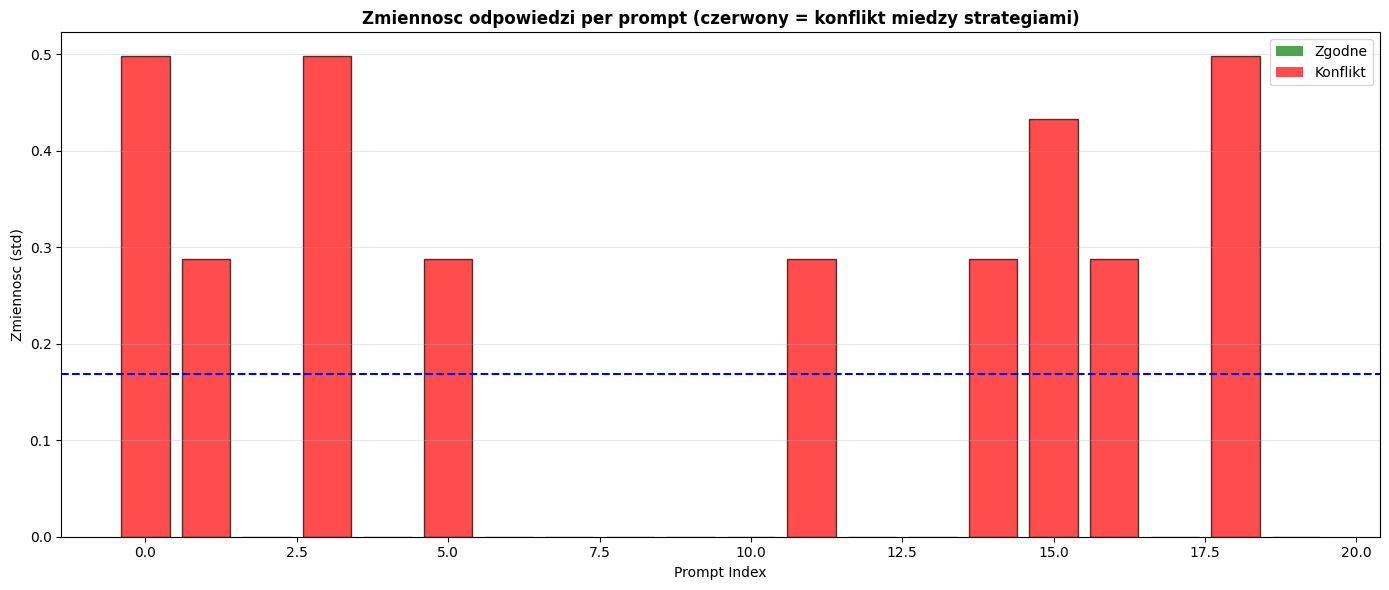


Konflikty: 9/20


In [46]:
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['red' if v['Conflict'] else 'green' for v in variability_per_prompt]
bars = ax.bar(range(len(variability_per_prompt)), 
              [v['Variability'] for v in variability_per_prompt],
              color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('Prompt Index')
ax.set_ylabel('Zmiennosc (std)')
ax.set_title('Zmiennosc odpowiedzi per prompt (czerwony = konflikt miedzy strategiami)', fontweight='bold')
ax.axhline(y=np.mean([v['Variability'] for v in variability_per_prompt]), 
           color='blue', linestyle='--', label='Srednia zmiennosc')
ax.grid(axis='y', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Zgodne'),
                   Patch(facecolor='red', alpha=0.7, label='Konflikt')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nKonflikty: {sum(1 for v in variability_per_prompt if v['Conflict'])}/{len(variability_per_prompt)}")

## 7. Transition Matrix

In [47]:
# Transition matrix - jak czę różnią się strategie
print("\n📊 TRANSITION MATRIX (różnice między strategiami)")
print("="*80)

strategies = parsed_df.columns.tolist()
n_strategies = len(strategies)
transition_matrix = np.zeros((n_strategies, n_strategies))

# Dla każdej pary strategii: w ile % się zgodziły
for i, strat1 in enumerate(strategies):
    for j, strat2 in enumerate(strategies):
        if i == j:
            transition_matrix[i, j] = 1.0  # Z sobą zawsze się zgadza
        else:
            # Porównaj odpowiedzi
            valid_mask = parsed_df[strat1].notna() & parsed_df[strat2].notna()
            if valid_mask.sum() > 0:
                agreement = (parsed_df.loc[valid_mask, strat1] == parsed_df.loc[valid_mask, strat2]).sum() / valid_mask.sum()
                transition_matrix[i, j] = agreement

transition_df = pd.DataFrame(transition_matrix, index=strategies, columns=strategies)

transition_path = os.path.join('saved_responses_groq', f'transition_matrix_{timestamp}.csv')
transition_df.to_csv(transition_path, encoding='utf-8-sig')

print(f"✓ Transition matrix saved to {transition_path}")
print(f"\nMediana agreement między strategiami: {np.median(transition_matrix[np.triu_indices_from(transition_matrix, k=1)]):.3f}")


📊 TRANSITION MATRIX (różnice między strategiami)
✓ Transition matrix saved to saved_responses_groq\transition_matrix_2025-12-31_00-47-50.csv

Mediana agreement między strategiami: 0.850


## WYKRES 3: Heatmap - Macierz przejsc

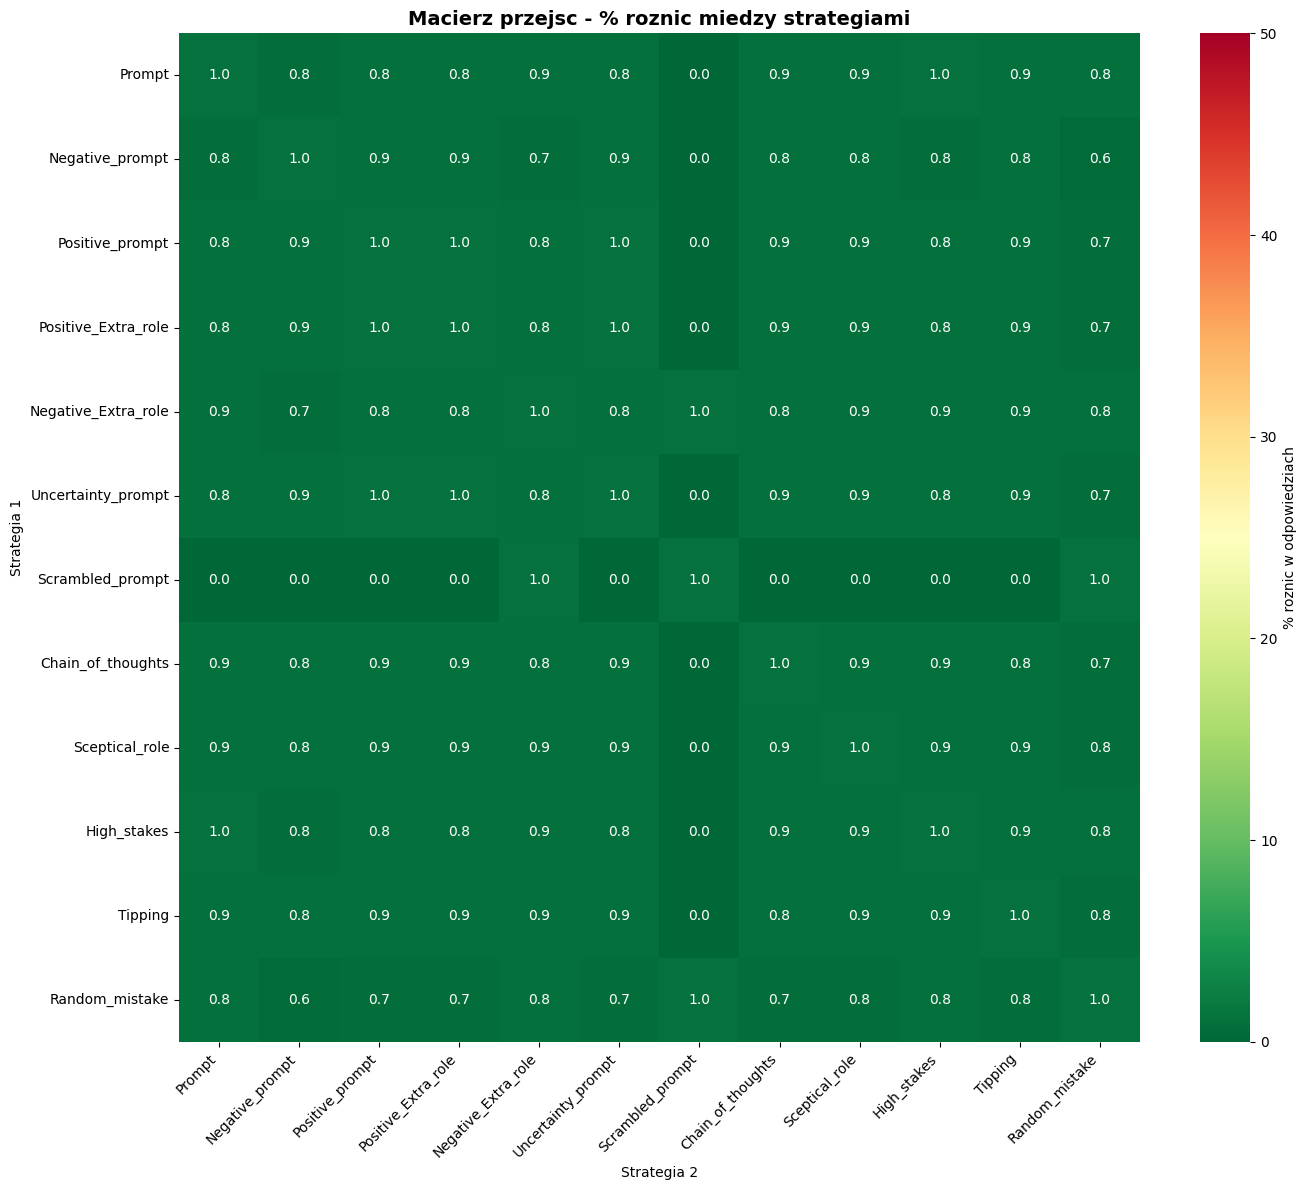

In [48]:
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(transition_matrix,
            xticklabels=parsed_df.columns,
            yticklabels=parsed_df.columns,
            annot=True, fmt='.1f', cmap='RdYlGn_r',
            cbar_kws={'label': '% roznic w odpowiedziach'},
            ax=ax, vmin=0, vmax=50)

ax.set_title('Macierz przejsc - % roznic miedzy strategiami', fontsize=14, fontweight='bold')
ax.set_xlabel('Strategia 2')
ax.set_ylabel('Strategia 1')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Risk Indicators

In [49]:
# Risk score per strategy - jak "zaufać" danej strategii?
print("\n⚠️ RISK INDICATORS PER STRATEGY")
print("="*80)

risk_list = []

for col in parsed_df.columns:
    y_pred = parsed_df[col].dropna().values
    
    if len(y_pred) == 0:
        continue
    
    # Variability of THIS strategy across prompts
    strat_variability = np.std(y_pred)
    
    # How often does it conflict with others?
    conflict_score = 0
    for other_col in parsed_df.columns:
        if col != other_col:
            valid_mask = parsed_df[col].notna() & parsed_df[other_col].notna()
            if valid_mask.sum() > 0:
                disagreement = (parsed_df.loc[valid_mask, col] != parsed_df.loc[valid_mask, other_col]).sum() / valid_mask.sum()
                conflict_score += disagreement
    
    conflict_score = conflict_score / (len(parsed_df.columns) - 1) if len(parsed_df.columns) > 1 else 0
    
    # Risk = variability + conflict
    risk_score = strat_variability * 0.5 + conflict_score * 0.5
    
    risk_list.append({
        'Strategy': col,
        'Variability': strat_variability,
        'Conflict_Score': conflict_score,
        'Risk_Score': risk_score
    })
    
    print(f"{col:25} | Var: {strat_variability:.3f} | Conflict: {conflict_score:.3f} | Risk: {risk_score:.3f}")

risk_df = pd.DataFrame(risk_list).sort_values('Risk_Score', ascending=False)

risk_path = os.path.join('saved_responses_groq', f'risk_indicators_{timestamp}.csv')
risk_df.to_csv(risk_path, index=False, encoding='utf-8-sig')
print(f"\n✓ Saved: {risk_path}")


⚠️ RISK INDICATORS PER STRATEGY
Prompt                    | Var: 0.400 | Conflict: 0.195 | Risk: 0.298
Negative_prompt           | Var: 0.497 | Conflict: 0.282 | Risk: 0.390
Positive_prompt           | Var: 0.477 | Conflict: 0.200 | Risk: 0.338
Positive_Extra_role       | Var: 0.477 | Conflict: 0.200 | Risk: 0.338
Negative_Extra_role       | Var: 0.357 | Conflict: 0.136 | Risk: 0.247
Uncertainty_prompt        | Var: 0.477 | Conflict: 0.200 | Risk: 0.338
Scrambled_prompt          | Var: 0.000 | Conflict: 0.818 | Risk: 0.409
Chain_of_thoughts         | Var: 0.458 | Conflict: 0.195 | Risk: 0.327
Sceptical_role            | Var: 0.433 | Conflict: 0.191 | Risk: 0.312
High_stakes               | Var: 0.400 | Conflict: 0.195 | Risk: 0.298
Tipping                   | Var: 0.433 | Conflict: 0.200 | Risk: 0.317
Random_mistake            | Var: 0.400 | Conflict: 0.259 | Risk: 0.330

✓ Saved: saved_responses_groq\risk_indicators_2025-12-31_00-47-50.csv


## WYKRES 4: Risk vs Accuracy - Trade-off

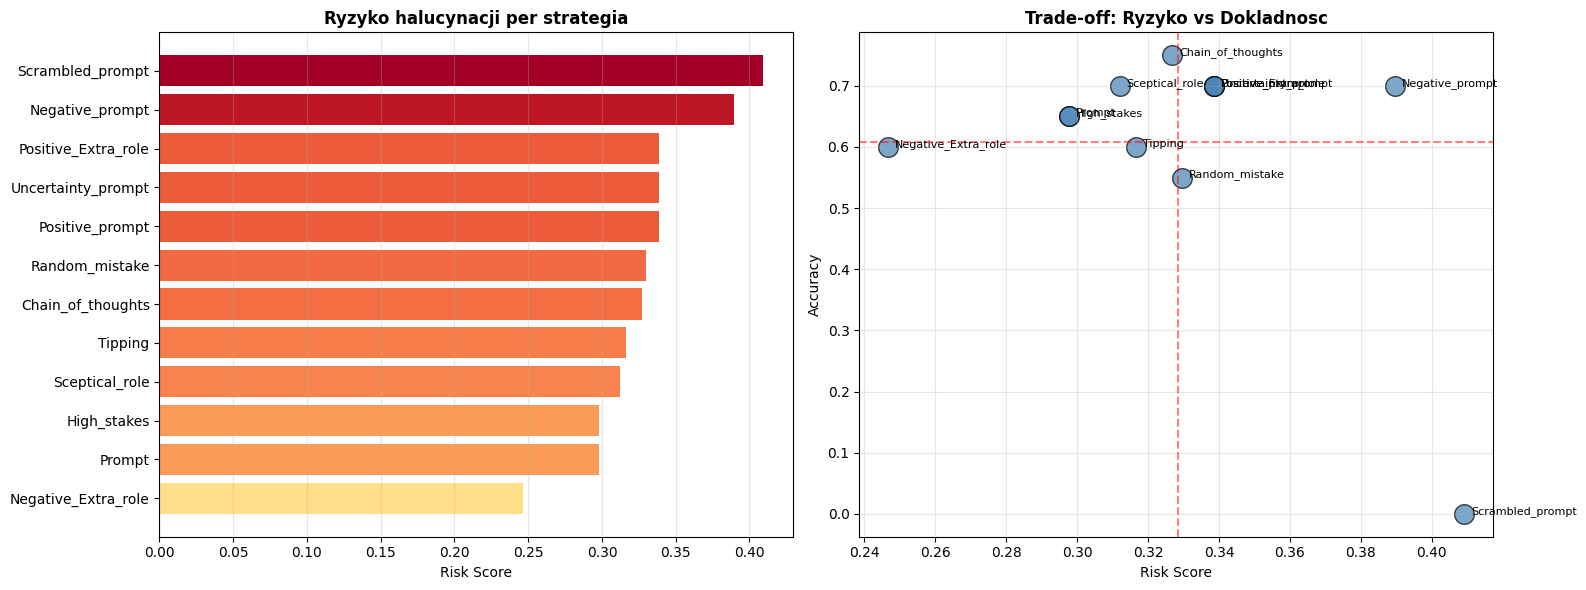

In [50]:
# Dolacz accuracy do risk_df
risk_with_acc = risk_df.merge(metrics_df[['Strategy', 'Accuracy']], on='Strategy', how='left')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Risk bar chart
risk_sorted = risk_with_acc.sort_values('Risk_Score', ascending=True)
colors = plt.cm.RdYlGn_r(risk_sorted['Risk_Score'] / max(risk_sorted['Risk_Score'].max(), 0.01))
ax1.barh(risk_sorted['Strategy'], risk_sorted['Risk_Score'], color=colors)
ax1.set_xlabel('Risk Score')
ax1.set_title('Ryzyko halucynacji per strategia', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Right: Scatter - Risk vs Accuracy
ax2.scatter(risk_with_acc['Risk_Score'], risk_with_acc['Accuracy'], s=200, alpha=0.7, c='steelblue', edgecolors='black')
for _, row in risk_with_acc.iterrows():
    ax2.annotate(row['Strategy'], (row['Risk_Score'], row['Accuracy']), 
                 fontsize=8, ha='left', xytext=(5, 0), textcoords='offset points')
ax2.set_xlabel('Risk Score')
ax2.set_ylabel('Accuracy')
ax2.set_title('Trade-off: Ryzyko vs Dokladnosc', fontweight='bold')
ax2.grid(alpha=0.3)
ax2.axhline(y=risk_with_acc['Accuracy'].mean(), color='red', linestyle='--', alpha=0.5)
ax2.axvline(x=risk_with_acc['Risk_Score'].mean(), color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 9. Podsumowanie - JSON Report

In [51]:
import json

report = {
    'Model': 'LLaMA 3.3 70B (Groq)',
    'Dataset_Size': len(df),
    'Strategies_Count': len(metrics_df),
    'Timestamp': timestamp,
    'Metrics': {
        'Best_Strategy': {
            'Name': metrics_df.iloc[0]['Strategy'],
            'Accuracy': float(metrics_df.iloc[0]['Accuracy']),
            'F1': float(metrics_df.iloc[0]['F1'])
        },
        'Worst_Strategy': {
            'Name': metrics_df.iloc[-1]['Strategy'],
            'Accuracy': float(metrics_df.iloc[-1]['Accuracy']),
            'F1': float(metrics_df.iloc[-1]['F1'])
        },
        'Average_Accuracy': float(metrics_df['Accuracy'].mean()),
        'Average_F1': float(metrics_df['F1'].mean())
    },
    'Hallucinations': {
        'Prompts_With_Conflict': int(conflict_count),
        'Conflict_Percentage': float(conflict_count / len(variability_df) * 100),
        'Average_Variability': float(variability_df['Variability'].mean()),
        'Max_Variability': float(variability_df['Variability'].max())
    },
    'Output_Files': {
        'Ranking': ranking_path,
        'Transition_Matrix': transition_path,
        'Risk_Indicators': risk_path,
        'Hallucination_Cases': hallucination_path if hallucination_cases else None
    }
}

report_path = os.path.join('saved_responses_groq', f'report_{timestamp}.json')
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print("\n" + "="*80)
print("📄 RAPORT KOŃCOWY")
print("="*80)
print(json.dumps(report, indent=2, ensure_ascii=False))
print(f"\n✓ Report saved: {report_path}")


📄 RAPORT KOŃCOWY
{
  "Model": "LLaMA 3.3 70B (Groq)",
  "Dataset_Size": 20,
  "Strategies_Count": 12,
  "Timestamp": "2025-12-31_00-47-50",
  "Metrics": {
    "Best_Strategy": {
      "Name": "Chain_of_thoughts",
      "Accuracy": 0.75,
      "F1": 0.8
    },
    "Worst_Strategy": {
      "Name": "Scrambled_prompt",
      "Accuracy": 0.0,
      "F1": 0.0
    },
    "Average_Accuracy": 0.6083333333333333,
    "Average_F1": 0.6751037542704209
  },
  "Hallucinations": {
    "Prompts_With_Conflict": 9,
    "Conflict_Percentage": 45.0,
    "Average_Variability": 0.168210021576415,
    "Max_Variability": 0.49792959773196915
  },
  "Output_Files": {
    "Ranking": "saved_responses_groq\\ranking_strategies_2025-12-31_00-47-50.csv",
    "Transition_Matrix": "saved_responses_groq\\transition_matrix_2025-12-31_00-47-50.csv",
    "Risk_Indicators": "saved_responses_groq\\risk_indicators_2025-12-31_00-47-50.csv",
    "Hallucination_Cases": "saved_responses_groq\\hallucination_cases_2025-12-31_00-4